<a href="https://colab.research.google.com/github/ai-fast-track/icedata/blob/add-plantdoc-dataset/notebooks/dev/plantdoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Oct 13 13:30:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Warning
This notebook is a work in progress document. We are sharing it with the IceVision Community through our Live Code Session (beginners-friendly). If you are interested in attending, please feel free to [join us](http://tinyurl.com/IceData)

## About the PlantDoc Dataset
PlantDoc is dataset for visual plant disease detection. It contains
2,598 data images with 13 plant species and 17 classesof diseases.

- Dataset [Repository](https://github.com/pratikkayal/PlantDoc-Object-Detection-Dataset)
- Paper: [PlantDoc: A Dataset for Visual Plant Disease Detection](https://arxiv.org/pdf/1911.10317.pdf)

# A Parser Example: Subclassing VocXmlParser parser
The PlantDoc Dataset provides both the VOC annoatation and a CSV annotation. 

> **Goal**: This notebook shows how to parse the PlantDoc dataset using 2 different methods:
- Using the Icevision default VOC parser
- Creating a new parser using the csv annotation file



## Installing IceVision

!!! warning "Google Colab Dependencies Incompatibilities "
    This issue is specific to Google Colab. The issue shouldn't occur on a local machine.
    Some of our external dependencies are not aligned with the dependencies pre-installed in Google Colab. 
    After pip installing both icevision and icedata (by runnning the cell here below), some errors will eventually pop up.
    To fix this issue, press the **RESTART RUNTIME** button.

In [ ]:
# Installing from PyPi
!pip install git+git://github.com/lgvaz/mantisshrimp.git@record_refactor#egg=icevision[all] --upgrade

# This a Colab issue, and here we are forcing the "Restart Runtime" programatically
import os
os.kill(os.getpid(), 9)

In [ ]:
# Instaling from GitHub master
# !pip install git+git://github.com/icevision/icevision.git#egg=icevision[all] --upgrade

## Imports

In [1]:
from icevision.all import *

## Clone the PlantDoc dataset repository


In [2]:
dataset_name = 'plantdoc'

In [3]:
!git clone https://github.com/pratikkayal/PlantDoc-Object-Detection-Dataset.git

Cloning into 'PlantDoc-Object-Detection-Dataset'...
remote: Enumerating objects: 5190, done.
remote: Total 5190 (delta 0), reused 0 (delta 0), pack-reused 5190
Receiving objects: 100% (5190/5190), 941.89 MiB | 62.83 MiB/s, done.
Resolving deltas: 100% (2328/2328), done.
Checking out files: 100% (5199/5199), done.


In [4]:
# Change current directory (use % instead of the usual !)
%cd PlantDoc-Object-Detection-Dataset/

/content/PlantDoc-Object-Detection-Dataset


In [5]:
!ls

LICENSE.txt  TEST  test_labels.csv  TRAIN  train_labels.csv


In [6]:
import pandas as pd

# Read csv file. rename the "class" column with "label" to avoid conflicts
train_labels = pd.read_csv('train_labels.csv')
train_labels.rename(columns={'class':'label'}, inplace=True)
train_labels.sample(5)

filename  ...  ymax
2854  white-mold-on-squash-plants-powdery-mildew-on-plant-leaves-how-to-get-rid-of-white-mold-on-squash-plants-white-mold-on-squash-plants.jpg  ...   184
3171                                                                                                                      wild-blueberries.jpg  ...  1087
115                                                                                                          possible-northerncornleafspot.jpg  ...  3264
8109                                                                                                                 Apple-Leaves-Diabetes.jpg  ...   169
3139                                                                                                               web1_cusoutherncornrust.jpg  ...   421

[5 rows x 8 columns]

### Define class_map

PlantDoc: a dataset of 2,598 images across 13 plant species and 27 classes(17-10, disease-healthy)

In [7]:
# Get the classes 
_CLASSES = train_labels["label"].unique().tolist()
_CLASSES

['Cherry leaf',
 'Peach leaf',
 'Corn leaf blight',
 'Apple rust leaf',
 'Potato leaf late blight',
 'Strawberry leaf',
 'Corn rust leaf',
 'Tomato leaf late blight',
 'Tomato mold leaf',
 'Potato leaf early blight',
 'Apple leaf',
 'Tomato leaf yellow virus',
 'Blueberry leaf',
 'Tomato leaf mosaic virus',
 'Raspberry leaf',
 'Tomato leaf bacterial spot',
 'Squash Powdery mildew leaf',
 'grape leaf',
 'Corn Gray leaf spot',
 'Tomato Early blight leaf',
 'Apple Scab Leaf',
 'Tomato Septoria leaf spot',
 'Tomato leaf',
 'Soyabean leaf',
 'Bell_pepper leaf spot',
 'Bell_pepper leaf',
 'grape leaf black rot',
 'Potato leaf',
 'Tomato two spotted spider mites leaf']

In [8]:
class_map = ClassMap(_CLASSES)

In [9]:
class_map.get_name('Potato leaf early blight')

10

### Set images and annotations directories

In [10]:
data_dir = Path('./TRAIN')

images_dir = data_dir
annotations_dir = data_dir

In [11]:
images_dir.ls()

(#4720) [Path('TRAIN/IMG_8502.JPG.xml'),Path('TRAIN/squash-with-mildew-2x.xml'),Path('TRAIN/tomato-leaf-6424287.xml'),Path('TRAIN/grayleafspot99a.xml'),Path('TRAIN/late_blight1.jpg'),Path('TRAIN/FJ_018_F16271-3.xml'),Path('TRAIN/Apple%20scab%20-%20late%20season%20infection%20on%20petiole%20and%20leaf%20underside.JPG.xml'),Path('TRAIN/IMG_2780.xml'),Path('TRAIN/tomato_D4a-TobRingspotVirus-1000077_zoom.xml'),Path('TRAIN/grayleafspothybrid.xml')...]

## Method 1: Using icevision predefined VOC parser

### Note
The PlantDoc dataset uses the VOC annotation. Both the individual annotation files and the image files are located in the **./TRAIN** folder.

In [12]:
parser = parsers.voc(annotations_dir=annotations_dir, images_dir=images_dir, class_map=class_map)

In [13]:
train_records, valid_records = parser.parse()

2020-10-13 13:33:37.447 | INFO     | icevision.core.record:_pre_replay:82 - Autofixing record with imageid: 2026


2020-10-13 13:33:37.445 | INFO     | icevision.core.bbox:autofix:70 - Clipping xmax from 430 to 0 (image width)
2020-10-13 13:33:37.445 | INFO     | icevision.core.bbox:autofix:73 - Clipping ymax from 628 to 0 (image height)
2020-10-13 13:33:37.445 | INFO     | icevision.core.record_mixins:_autofix:132 - Failed to fix: <BBox (xmin:55, ymin:1, xmax:0, ymax:0)>
2020-10-13 13:33:37.445 | INFO     | icevision.core.record:autofix:43 - Removed annotation with index: 0
2020-10-13 13:33:38.570 | INFO     | icevision.core.record:_pre_replay:82 - Autofixing record with imageid: 1912
2020-10-13 13:33:38.568 | INFO     | icevision.core.bbox:autofix:70 - Clipping xmax from 566 to 0 (image width)
2020-10-13 13:33:38.568 | INFO     | icevision.core.bbox:autofix:73 - Clipping ymax from 192 to 0 (image height)
2020-10-13 13:33:38.568 | INFO     | icevision.core.record_mixins:_autofix:132 - Failed to fix: <BBox (xmin:78, ymin:1, xmax:0, ymax:0)>
2020-10-13 13:33:38.568 | INFO     | icevision.core.record

In [15]:
train_records[0].bboxes

[<BBox (xmin:1, ymin:1, xmax:432, ymax:270)>]

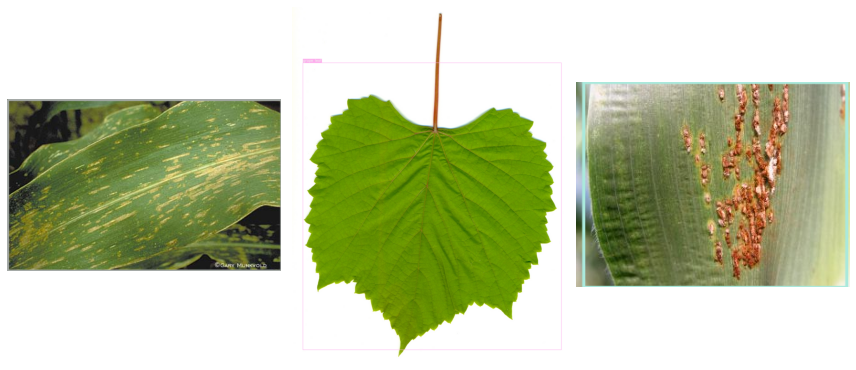

In [16]:
show_records(train_records[:3], ncols=3, class_map=class_map)

## Method 2: Creating a new parser from *scratch*

In [20]:
class PlantDocParser(parsers.FasterRCNN, parsers.FilepathMixin, parsers.SizeMixin):
    def __init__(self, df, source, class_map):
        self.df = df
        self.source = source
        self.class_map = class_map

    # def chexk_file(self, ):

    def __iter__(self):
        # yield from self.df.itertuples()
        items = self.df.itertuples()
        for item in items:
            fn = self.source / item.filename
            if fn.exists():
                yield item

    def __len__(self):
        return len(self.df)

    def prepare(self, o):
      fn = self.source / o.filename
      self._height, self._width, c = open_img(fn).shape     

    def imageid(self, o) -> Hashable:
        return Path(o.filename).stem

    def filepath(self, o) -> Union[str, Path]:
        return self.source / o.filename

    def image_height(self, o) -> int:
        return self._height

    def image_width(self, o) -> int:
        return self._width

    def labels(self, o) -> List[int]:
        return [class_map.get_name(o.label)]

    def bboxes(self, o) -> List[BBox]:
        xmin = o.xmin
        xmax = o.xmax
        ymin = o.ymin
        ymax = o.ymax
        return [BBox.from_xyxy(xmin, ymin, xmax, ymax)]

In [21]:
source = Path("./TRAIN")
parser_csv = PlantDocParser(train_labels, source=source, class_map=class_map)

In [22]:
train_records_csv, valid_records_csv = parser_csv.parse()

2020-10-13 13:40:29.087 | INFO     | icevision.core.record:_pre_replay:82 - Autofixing record with imageid: 1593
2020-10-13 13:40:29.084 | INFO     | icevision.core.bbox:autofix:70 - Clipping xmax from 3264 to 500 (image width)
2020-10-13 13:40:29.085 | INFO     | icevision.core.bbox:autofix:73 - Clipping ymax from 2274 to 375 (image height)
2020-10-13 13:40:29.209 | INFO     | icevision.core.record:_pre_replay:82 - Autofixing record with imageid: 2016
2020-10-13 13:40:29.206 | INFO     | icevision.core.bbox:autofix:70 - Clipping xmax from 2255 to 1936 (image width)
2020-10-13 13:40:29.206 | INFO     | icevision.core.record_mixins:_autofix:132 - Failed to fix: <BBox (xmin:1961, ymin:97, xmax:1936, ymax:843)>
2020-10-13 13:40:29.206 | INFO     | icevision.core.bbox:autofix:70 - Clipping xmax from 2253 to 1936 (image width)
2020-10-13 13:40:29.207 | INFO     | icevision.core.bbox:autofix:70 - Clipping xmax from 2001 to 1936 (image width)
2020-10-13 13:40:29.207 | INFO     | icevision.cor

2020-10-13 13:40:29.355 | INFO     | icevision.core.bbox:autofix:70 - Clipping xmax from 3613 to 3024 (image width)
2020-10-13 13:40:29.419 | INFO     | icevision.core.record:_pre_replay:82 - Autofixing record with imageid: 1213
2020-10-13 13:40:29.417 | INFO     | icevision.core.bbox:autofix:70 - Clipping xmax from 622 to 600 (image width)
2020-10-13 13:40:29.417 | INFO     | icevision.core.bbox:autofix:70 - Clipping xmax from 748 to 600 (image width)
2020-10-13 13:40:29.778 | INFO     | icevision.core.record:_pre_replay:82 - Autofixing record with imageid: 188
2020-10-13 13:40:29.775 | INFO     | icevision.core.bbox:autofix:70 - Clipping xmax from 2409 to 1944 (image width)
2020-10-13 13:40:29.775 | INFO     | icevision.core.bbox:autofix:70 - Clipping xmax from 1961 to 1944 (image width)
2020-10-13 13:40:29.776 | INFO     | icevision.core.bbox:autofix:70 - Clipping xmax from 2107 to 1944 (image width)
2020-10-13 13:40:31.315 | INFO     | icevision.core.record:_pre_replay:82 - Autofix

In [23]:
!ls TRAIN/NCLB.jpg

ls: cannot access 'TRAIN/NCLB.jpg': No such file or directory


In [30]:
train_records_csv[15].bboxes

[<BBox (xmin:12, ymin:191, xmax:389, ymax:839)>,
 <BBox (xmin:152, ymin:20, xmax:472, ymax:680)>,
 <BBox (xmin:440, ymin:250, xmax:771, ymax:677)>,
 <BBox (xmin:629, ymin:355, xmax:1164, ymax:834)>,
 <BBox (xmin:788, ymin:114, xmax:1190, ymax:335)>,
 <BBox (xmin:478, ymin:91, xmax:886, ymax:435)>]

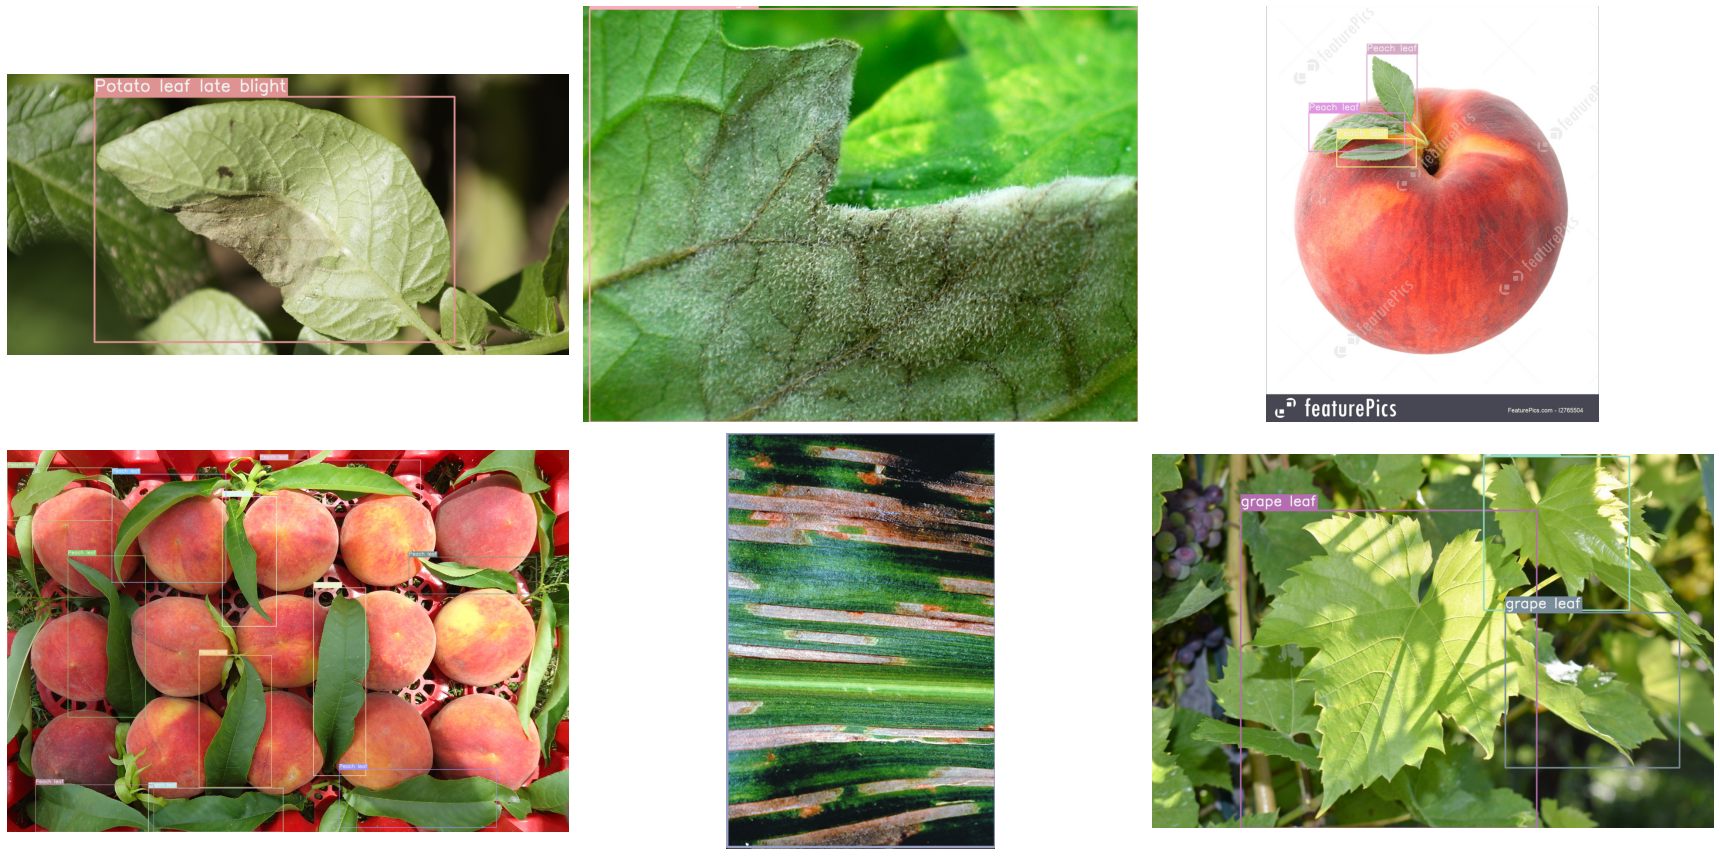

In [31]:
show_records(train_records_csv[:6], ncols=3, class_map=class_map)

### train and validation records

## Datasets
### Transforms

In [32]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
# train_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

### Train and Validation Dataset Objects

In [33]:
train_ds = Dataset(train_records_csv, train_tfms)
valid_ds = Dataset(valid_records_csv, valid_tfms)

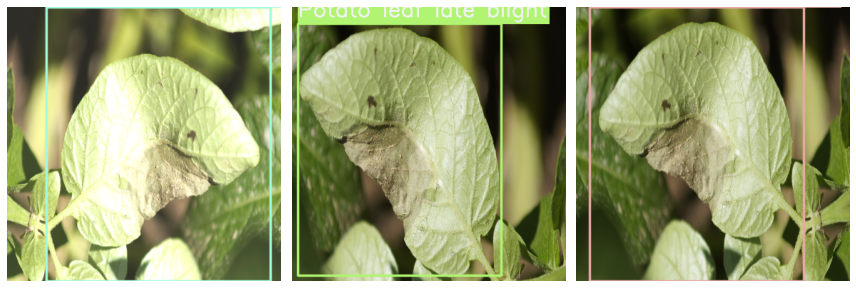

In [35]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, class_map=class_map, denormalize_fn=denormalize_imagenet, ncols=3)

### DataLoaders

### Warning
As for now, EfficientDet doesn't work well for this dataset because some predictions return one-pixel or one-line bboxes. We need to further investigate that in order to find out the source of the problem and how it can be fixed

In [36]:
model_type = efficientdet # faster_rcnn # efficientdet

In [37]:
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

### Model

In [38]:
model = model_type.model('tf_efficientdet_lite0', num_classes=len(class_map), img_size=size)
# model = model_type.model(num_classes=len(class_map))

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_lite0-f5f303a9.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientdet_lite0-f5f303a9.pth


### Fastai Learner

In [39]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [40]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

## Fastai Training
### Learning Rate Finder

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)

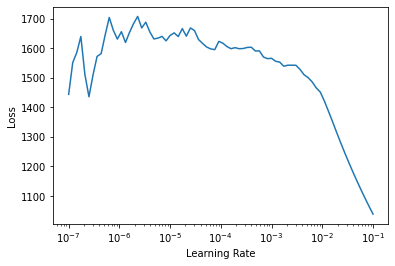

In [41]:
learn.freeze()
learn.lr_find()

### Fine tune: 2 Phases
- Phase 1: Train the head for 3 epochs while freezing the body
- Phase 2: Train both the body and the head during 50 epochs

In [51]:
fname_model_best = "plantdoc-efficientdet-best"

In [50]:
from fastai.callback.tracker import SaveModelCallback
learn.fine_tune(10, 0.012, freeze_epochs=3, cbs=SaveModelCallback(monitor='COCOMetric', fname=fname_model_best))

Better model found at epoch 0 with COCOMetric value: 0.0027608246591410745.
Better model found at epoch 1 with COCOMetric value: 0.002807455213193242.
Better model found at epoch 2 with COCOMetric value: 0.009692459528093307.


Better model found at epoch 0 with COCOMetric value: 0.024777058851787773.
Better model found at epoch 1 with COCOMetric value: 0.03749013751071579.
Better model found at epoch 2 with COCOMetric value: 0.03852301807011789.
Better model found at epoch 3 with COCOMetric value: 0.05478505079888.
Better model found at epoch 4 with COCOMetric value: 0.08348879776240721.
Better model found at epoch 6 with COCOMetric value: 0.10811740268423028.
Better model found at epoch 7 with COCOMetric value: 0.14043799307254806.
Better model found at epoch 8 with COCOMetric value: 0.1406521852299911.
Better model found at epoch 9 with COCOMetric value: 0.1451228535030818.


## Show results

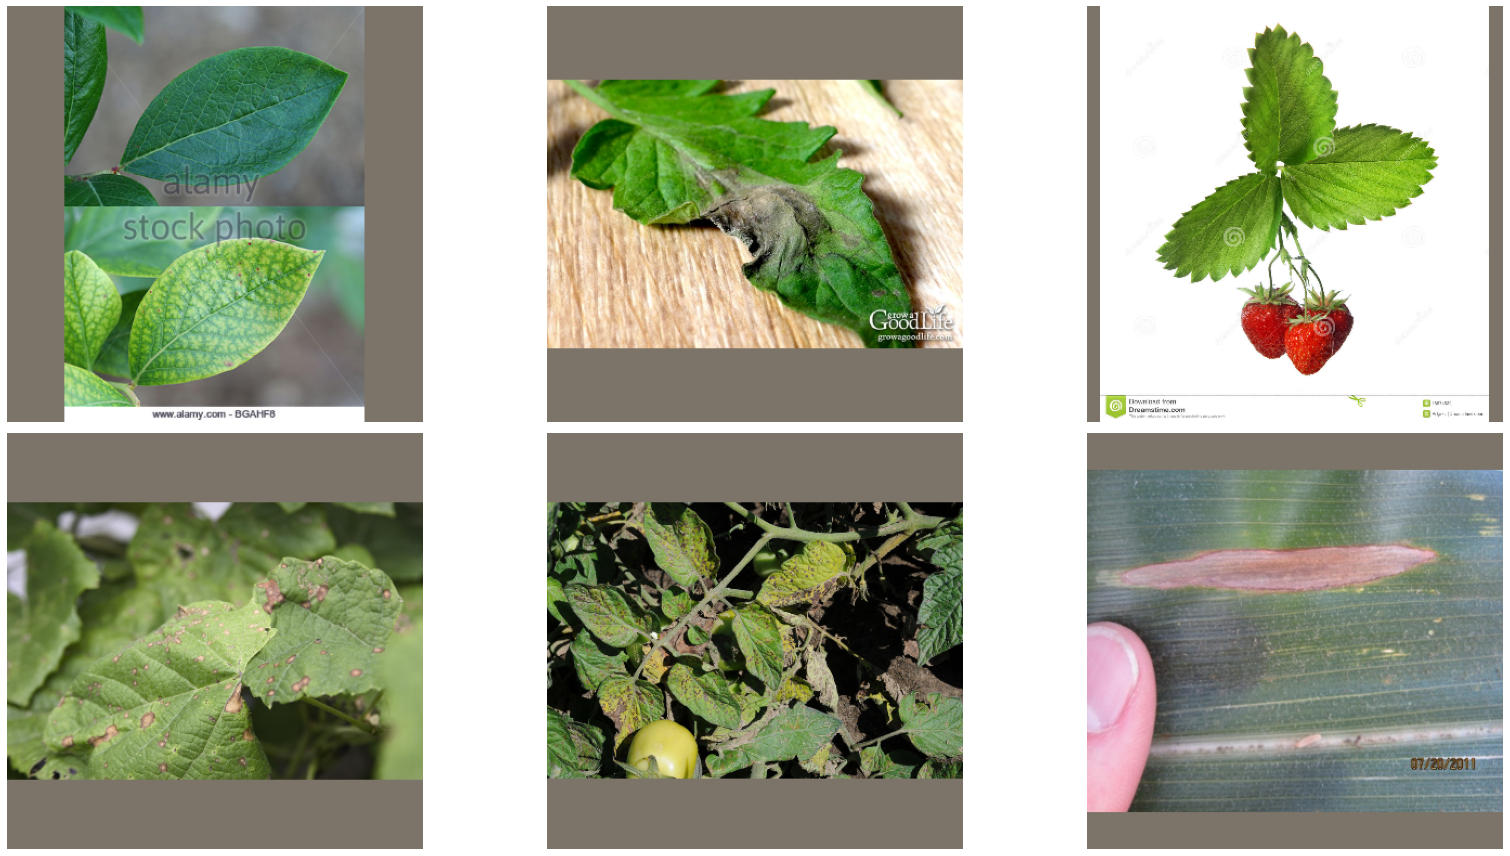

In [52]:
model_type.show_results(model, valid_ds, class_map=class_map)

## Saving a Model on Google Drive

>Note: In this example, we suppose you have already created a folder called **models** in your Google Drive

In [ ]:
## Mount your Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

Mounted at /content/gdrive


### Saving the last model

In [ ]:
fname_model = "plantdoc-efficientdet.pth'
torch.save(model.state_dict(), root_dir/'models'/fname_model)

### Saving the best model

In [ ]:
!ls models

In [ ]:
!cp models/plantdoc-efficientdet-best.pth /content/gdrive/"My Drive"/models/plantdoc-efficientdet-best.pth

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).